In [1]:
# from Algorithm 1: HMC, page1353
def Leapfrog(theta, r, grad, eps, L):
    r_tilde = r + (eps/2) * grad
    theta_tilde = theta + eps * r_tilde
    logp_tilde, grad_tilde = L(theta_tilde)
    r_tilde = r_tilde + (eps/2) * grad_tilde
    return theta_tilde, r_tilde, grad_tilde, logp_tilde

In [2]:
def FindReasonableEpsilon(theta, grad, logp, L):
    #initialize
    parems = len(theta)
    eps = 1
    r = np.random.multivariate_normal(np.zeros(parems), np.identity(parems), 1)
    r = r.ravel()
    theta_prime, r_prime, _, logp_prime = Leapfrog(theta, r, grad, eps, L)
    
    prob = np.exp(logp_prime - logp - 0.5 * (np.dot(r_prime, r_prime) - np.dot(r, r)))
    a = 2 * int(prob > 0.5) - 1

    while prob**a > 2**(-a):
        eps = 2**a * eps
        theta_prime, r_prime, _, logp_prime = Leapfrog(theta, r, grad, eps, L);
        prob = np.exp(logp_prime - logp - 0.5 * (np.dot(r_prime, r_prime) - np.dot(r,r)))
    return eps

In [3]:
def BuildTree(theta, r, grad, u, v, j, eps, L, esto0):
    if j == 0: 
        # base case, take one leapfrog step in the direction v
        theta_prime, r_prime, grad_prime, logp_prime = Leapfrog(theta, r, grad, v*eps, L)
        
        esto = logp_prime - 0.5 * np.dot(r_prime, r_prime)

        n_prime = int(u <= np.exp(esto))
        
        s_prime = int(esto > np.log(u) - 1000)

        alpha_prime = min(1, np.exp(esto - esto0))
                                                   
        return theta_prime, r_prime, grad_prime, theta_prime, r_prime, grad_prime, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha_prime, 1
    else:
        # recursion, build left and right subtrees
        theta_minus, r_minus, grad_minus, theta_plus, r_plus, grad_plus, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha_prime, n_alpha_prime = BuildTree(theta, r, grad, u, v, j-1, eps, L, esto0)
        
        if s_prime == 1:
            if v == -1:
                theta_minus, r_minus, grad_minus, _,_,_, theta_doub_prime, grad_doub_prime, logp_doub_prime, n_doub_prime, s_doub_prime, alpha_doub_prime, n_alpha_doub_prime = BuildTree(theta_minus, r_minus, grad_minus, u, v, j-1, eps, L, esto0)
            else:
                _, _, _, theta_plus, r_plus, grad_plus, theta_doub_prime, grad_doub_prime, logp_doub_prime, n_doub_prime, s_doub_prime, alpha_doub_prime, n_alpha_doub_prime = BuildTree(theta_plus, r_plus, grad_plus, u, v, j-1, eps, L, esto0)

            # Use Metropolis-Hastings
            prob = n_doub_prime / max(n_prime + n_doub_prime,1)
            if (np.random.uniform(0, 1, 1) < prob):
                theta_prime = theta_doub_prime
                grad_prime = grad_doub_prime
                logp_prime = logp_doub_prime
            
            ind_1 = int(np.dot(theta_plus-theta_minus, r_minus) >= 0)
            ind_2 = int(np.dot(theta_plus-theta_minus, r_plus) >= 0)
            s_prime = s_prime * s_doub_prime * ind_1 * ind_2
            n_prime = n_prime + n_doub_prime
            alpha_prime = alpha_prime + alpha_doub_prime
            n_alpha_prime = n_alpha_prime + n_alpha_doub_prime
        
        return theta_minus, r_minus, grad_minus, theta_plus, r_plus, grad_plus, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha_prime, n_alpha_prime

In [4]:
def nuts6_dual_averaging(theta0, M, M_adapt, L, delta = 0.6):
    # initialize samples matrix
    # put initial theta0 in first row of matrix
    parems = len(theta0)
    samples = np.empty((M+1, parems))
    samples[0, :] = theta0
    logp, grad = L(theta0)
    eps = FindReasonableEpsilon(theta0, grad, logp, L)
    mu = np.log(10*eps)
    eps_bar = 1
    H_bar = 0
    gamma = 0.05
    t0 = 10
    k = 0.75
    
    for m in range(1, M+1):
        # resample
        norm_samp = np.random.multivariate_normal(np.zeros(parems), np.identity(parems), 1)
        r0 = norm_samp.ravel()

        esto = logp - 0.5 * np.dot(r0,r0)
        # resample u ~ uniform([0, exp(inside)])
        u = np.random.uniform(0, np.exp(esto), 1)

        # initialize minus's and plus's
        theta_minus = samples[m-1, :]
        theta_plus = samples[m-1, :]
        r_minus = r0
        r_plus = r0
        j = 0
        grad_minus = grad
        grad_plus = grad
        
        j = 0
        samples[m, :] = samples[m-1, :]
        n = 1
        s = 1
        
        while s == 1:
            v_j = np.random.uniform(-1,1,1)
            if v_j == -1:
                theta_minus, r_minus, grad_minus, _, _, _, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha, n_alpha = BuildTree(theta_minus, r_minus, grad_minus, u, v_j, j, eps, L, esto)
            else:
                _, _, _, theta_plus, r_plus, grad_plus, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha, n_alpha = BuildTree(theta_plus, r_plus, grad_plus, u, v_j, j, eps, L, esto)
            
            if s_prime == 1:
                # Use Metropolis-Hastings
                prob = min(1, n_prime/n)
                if (np.random.uniform(0,1,1) < prob):
                    samples[m, :] = theta_prime
                    logp = logp_prime
                    grad = grad_prime
                    
            n = n + n_prime

            boolean_1 = int(np.dot(theta_plus-theta_minus, r_minus) >= 0)
            boolean_2 = int(np.dot(theta_plus-theta_minus, r_plus) >= 0)
            s = s_prime * boolean_1 * boolean_2
            j = j + 1
            
        if m <= M_adapt:
            H_bar = (1 - 1/(m+t0))*H_bar + (1/(m+t0)) * (delta - alpha/n_alpha)
            eps = np.exp(mu - np.sqrt(m)/gamma * H_bar)
            eps_bar = np.exp(m**(-k) * np.log(eps) + (1-m**(-k))*np.log(eps_bar))
        else:
            eps = eps_bar
            
    burned_in = samples[M_adapt+1:M+1, :]
    return samples, burned_in

In [5]:
#X = np.random.poisson(5, 100)
#N = 100
#def L(theta):
#    grad = sum(X) / theta - N
#    logp = sum(X)*np.log(theta) - theta*N
#    return logp, grad
#np.mean(X)

In [6]:
# simple example
#theta0 = np.array([10])
#M = 10000
#M_adapt = 1000
#samples, burned_in = nuts6_dual_averaging(theta0, M, M_adapt, L, delta = 0.6)
#np.mean(burned_in)

In [7]:
# multivariate normal
mean = np.ones(50)
cov = np.identity(50)
X = np.random.multivariate_normal(mean, cov, 500)

In [8]:
sample_mean = np.mean(X, axis = 0)

In [9]:
def L_MVN(theta):
    cumsum = 0
    grad = 0
    for x in X:
        cumsum += ((x - theta).T @ np.linalg.inv(cov)) @ (x - theta)
        grad += (x - theta).T @ np.linalg.inv(cov) 
    logp = -0.5 * cumsum
    return logp, grad

In [10]:
#def L_MVN(theta):
#    cumsum = ((theta).T @ np.linalg.inv(cov)) @ (theta)
#    grad = (theta).T @ np.linalg.inv(cov) 
#    logp = -0.5 * cumsum
#    return logp, grad

In [11]:
%%time
# run for normal
theta0 = np.zeros(50)
M = 5000
M_adapt = 1000

samples, burned_in = nuts6_dual_averaging(theta0, M, M_adapt, L_MVN, delta = 0.6)


CPU times: user 1min 42s, sys: 38.9 s, total: 2min 20s
Wall time: 1min 33s


In [12]:
unique_samples = np.array([samples[0,:]])
# subset just accepted theta's
for i in range(1, M):
    if all(samples[i-1,:] != samples[i,:]):
        unique_samples = np.vstack([unique_samples, samples[i]])
        

In [13]:
np.mean(burned_in, axis = 0)

array([  3.36955369e+82,   4.20896144e+82,   3.66029691e+82,
         3.77231634e+82,   3.18985147e+82,   3.63166559e+82,
         3.32131803e+82,   2.95968886e+82,   4.04542050e+82,
         4.03888553e+82,   3.04429898e+82,   5.27865074e+82,
         3.07386616e+82,   3.88893553e+82,   3.65443065e+82,
         3.37777078e+82,   2.96271385e+82,   3.41289063e+82,
         3.79757002e+82,   2.95489897e+82,   4.16897328e+82,
         4.69875960e+82,   3.20232910e+82,   4.54250810e+82,
         2.53413722e+82,   3.48890868e+82,   3.92406206e+82,
         3.42033573e+82,   2.28749190e+82,   3.09618188e+82,
         4.02272887e+82,   3.80273158e+82,   3.88549938e+82,
         4.56317587e+82,   4.20429165e+82,   4.19260541e+82,
         3.06483731e+82,   4.88167158e+82,   3.77786360e+82,
         3.89327274e+82,   4.28192374e+82,   3.35155870e+82,
         3.58091605e+82,   3.57717220e+82,   3.31738856e+82,
         3.80148502e+82,   3.76100201e+82,   4.29199450e+82,
         2.90864365e+82,

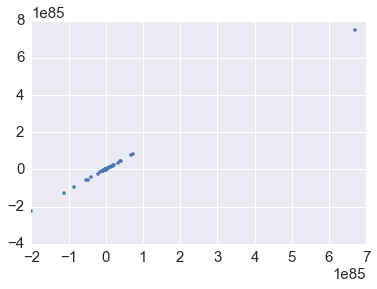

In [14]:
plt.plot(samples[1:M,0], samples[1:M,3], ".")
plt.plot(unique_samples[1:50,0], unique_samples[1:50,3], 'r')

In [43]:
import pymc3 as pm
import numpy.random as rng
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

In [44]:
niter = 7000
with pm.Model() as test_context:
    mu = pm.MvNormal('mu', 0, tau=cov, shape=5)
    y = pm.MvNormal('y', mu=mu, tau= cov, observed=X)
    step = pm.Metropolis()
    trace = pm.sample(niter,step=step)

 [-----------------100%-----------------] 7000 of 7000 complete in 0.8 sec

In [45]:
metropolis_samples = trace['mu']


In [46]:
unique_samples_met = np.array([metropolis_samples[0,:]])
# subset just accepted theta's
for i in range(1, niter):
    if all(metropolis_samples[i-1,:] != metropolis_samples[i,:]):
        unique_samples_met = np.vstack([unique_samples_met, metropolis_samples[i]])   

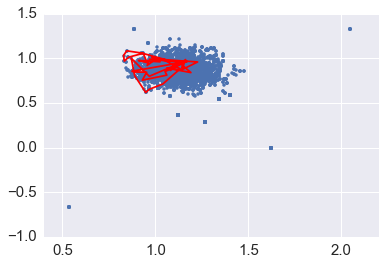

In [50]:
plt.plot(metropolis_samples[0:M,0], metropolis_samples[0:M,3], ".")
plt.plot(unique_samples_met[0:50,0], unique_samples_met[0:50,3], 'r')